In [33]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
# Loading file paths
train_path = f'E:/CMAPSS/data/train_FD00X.txt'
test_path = f'E:/CMAPSS/data/test_FD00X.txt'

"""Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16."""

cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']
labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # for 22 sensors


In [5]:
# Preparing files
def load_data(filepath):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    for i in range(1, 5):
        data.append(pd.read_csv(filepath.replace('X', str(i)),
                                names=labels, delimiter='\s+',
                                dtype=np.float32))
        if i == 1 or i == 3:
            data[i - 1].drop(cols_to_drop, axis=1, inplace=True)
        if i == 4 or i == 2:
            data[i - 1].drop('sensor16', axis=1, inplace=True)
    return data  # a list

def prepare_data(data: pd.DataFrame):
    # Drops redundant columns and adds an RUL column for training
    rul = pd.DataFrame(data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    data = data.merge(rul, on=['unit'], how='left')

    data['RUL'] = data['max'] - data['cycles']
    data.drop('max', axis=1, inplace=True)
    return data

def create_training_sequence(df, seq_length, seq_cols):
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array = []

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)


def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [8]:
# Initialising data
train_data = load_data(train_path)
test_data = load_data(test_path)

for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])

scaler = MinMaxScaler(feature_range=(-1, 1))

for df in train_data:
    df.iloc[:, 2:-1] = scaler.fit_transform(df.iloc[:, 2:-1])
x_FD001_columns = [column for column in train_data[0] if column != 'RUL']

In [9]:
# Model parameters
sequence_len = 10
FD001 = train_data[0]
FD002 = train_data[1]
FD002 = train_data[2]
FD003 = train_data[3]
x_train_FD001 = np.concatenate(list(list(create_training_sequence(FD001[FD001['unit'] == i], sequence_len, x_FD001_columns)) for unit in train_data[0]['unit'].unique()))
print("x_train:", x_train_FD001.shape)
y_train_FD001 = np.concatenate(list(list(create_target_sequence(FD001[FD001['unit'] == i], sequence_len, 'RUL')) for unit in train_data[0]['unit'].unique()))
print("y_train:", y_train_FD001.shape)

x_train: (17000, 10, 17)
y_train: (17000,)


In [10]:
feature_count = x_train_FD001.shape[2]  
out_dim = 1

model = Sequential()
model.add(LSTM(
    units=128,
    return_sequences=True,
    input_shape=(sequence_len, feature_count)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(
    units=56,
    return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation('relu'))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])
model.summary()

E:\CMAPSS\code\tft_new_2_311\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        74,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 56)             │        41,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            57 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,761 (456.10 KB)

 Trainable params: 116,505 (455.10 KB)

 Non-trainable params: 256 (1.00 KB)

In [31]:
history = model.fit(x_train_FD001, y_train_FD001, epochs=20, batch_size=32, validation_split=0.2, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 38.5685 - mse: 38.5685 - val_loss: 0.4444 - val_mse: 0.4444
Epoch 2/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 36.7929 - mse: 36.7929 - val_loss: 1.1841 - val_mse: 1.1841
Epoch 3/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 39.4438 - mse: 39.4438 - val_loss: 3.5460 - val_mse: 3.5460
Epoch 4/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 36.4858 - mse: 36.4858 - val_loss: 0.8714 - val_mse: 0.8714
Epoch 5/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 38.4918 - mse: 38.4918 - val_loss: 2.6557 - val_mse: 2.6557
Epoch 6/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 40.3862 - mse: 40.3862 - val_loss: 1.0357 - val_mse: 1.0357
Epoch 7/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 38.8273 - mse: 38.8273 - val_loss: 0.9456 - val_mse: 0.9456
Epoch 8/15
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 36.5902 - mse: 36.5902 - val_loss: 1.2660 - val_mse: 1.2660
Epoch 9/15
425/425 ━━━━━━━━━━━━━

In [37]:
model.save('E:/CMAPSS/code/tft_new_2_311/models/LSTM.keras')
checkpoint = ModelCheckpoint('E:/CMAPSS/code/tft_new_2_311/models/LSTM.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

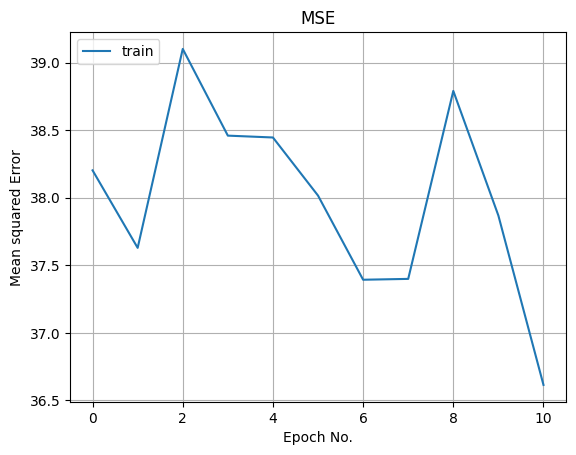

In [38]:
plt.plot(history.history['mse'])
plt.title('MSE')

plt.ylabel('Mean squared Error')
plt.xlabel('Epoch No.')
plt.legend(['train'], loc='upper left')
plt.grid()
plt.show()


In [39]:
scores = model.evaluate(x_train_FD001, y_train_FD001, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5997 - mse: 0.5997
MSE: 0.596653401851654


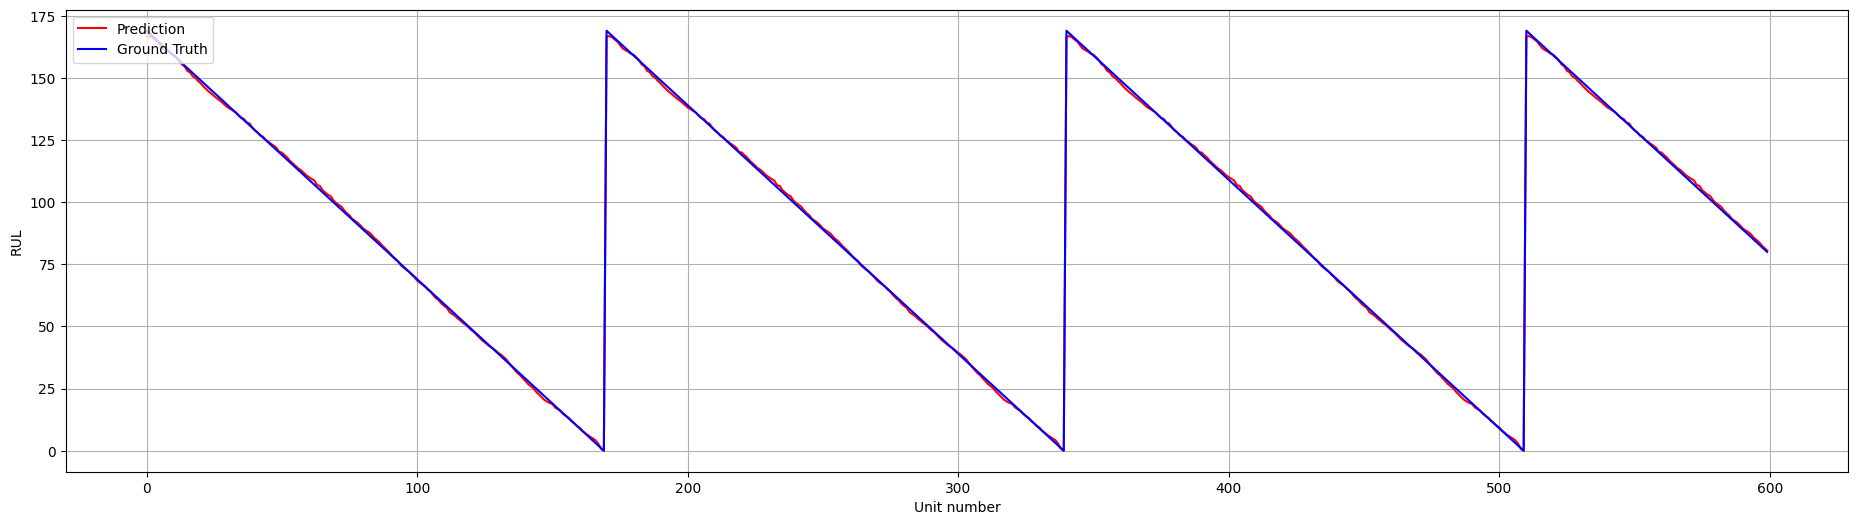

In [40]:
y_pred_test = model.predict(x_train_FD001[0:600], verbose=0)
plt.figure(figsize=(23,6))
plt.plot(y_pred_test, color='red', label="Prediction")
plt.plot(y_train_FD001[0:600], color='blue', label='Ground Truth')
plt.ylabel('RUL')
plt.xlabel('Unit number')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [42]:
# testing actual data

x_test_FD001 = np.concatenate(list(list(create_target_sequence)))

[169. 168. 167. 166. 165. 164. 163. 162. 161. 160. 159. 158. 157. 156.
 155. 154. 153. 152. 151. 150. 149. 148. 147. 146. 145. 144. 143. 142.
 141. 140. 139. 138. 137. 136. 135. 134. 133. 132. 131. 130. 129. 128.
 127. 126. 125. 124. 123. 122. 121. 120.]
